# Data Exploration

This notebook visualizes the gravitational wave data used to train the detection model. The goal is to build intuition for what the raw signals look like, why preprocessing is necessary, and what features distinguish a real signal from noise.

For the underlying physics and signal processing theory, see [THE_SCIENCE.md](../THE_SCIENCE.md). For the model itself, see [02_model_explorer.ipynb](02_model_explorer.ipynb).

> **Dataset** -- This notebook needs raw samples from the
> [G2Net Gravitational Wave Detection](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection)
> competition. If the full dataset (~70 GB) is not available locally, it will
> automatically download a 1000-sample exploration subset (~100 MB) from Kaggle.
> See `src/data/g2net.py` for the full search order.

## 1. The Raw Data

In [23]:
from __future__ import annotations
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# find project root and add src to path
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "src").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

from data.g2net import find_dataset_dir, download_sample_dataset, load_labels, load_sample, sample_dataset_dir
from data.preprocessing import (
    preprocess_sample, bandpass_filter, whiten_signal, apply_tukey_window, load_psd,
    FS, N,
)
from visualization import (
    plot_preprocessing_pipeline, plot_cross_detector_correlation, DETECTOR_NAMES,
)

# dataset
try:
    DATASET_DIR = find_dataset_dir()
except FileNotFoundError:
    DATASET_DIR = download_sample_dataset()

labels_df = load_labels(DATASET_DIR)

T = np.arange(N) / FS  # time axis (s)

n_samples = len(labels_df)
n_signal = (labels_df["target"] == 1).sum()
n_noise = (labels_df["target"] == 0).sum()
print(f"Dataset: {DATASET_DIR}")
print(f"Samples: {n_samples:,} ({n_signal:,} signal, {n_noise:,} noise)")
if n_samples < 10_000:
    print(f"NOTE: running on exploration sample ({n_samples} samples). "
          "Attach the full dataset for complete exploration.")

Dataset: D:\Programming\g2net-gravitational-wave-detection
Samples: 560,000 (279,930 signal, 280,070 noise)


In [24]:
# load one signal sample and one noise sample
signal_row = labels_df[labels_df["target"] == 1].iloc[0]
noise_row = labels_df[labels_df["target"] == 0].iloc[0]

raw_signal = load_sample(signal_row["id"], dataset_dir=DATASET_DIR)
raw_noise = load_sample(noise_row["id"], dataset_dir=DATASET_DIR)

print(f"Signal sample: {signal_row['id']}  shape={raw_signal.shape}  dtype={raw_signal.dtype}")
print(f"Noise sample:  {noise_row['id']}  shape={raw_noise.shape}  dtype={raw_noise.dtype}")
print(f"\nStrain scale: {raw_signal.std():.2e} (typical ~1e-21)")

Signal sample: 00000e74ad  shape=(3, 4096)  dtype=float64
Noise sample:  00001f4945  shape=(3, 4096)  dtype=float64

Strain scale: 4.94e-21 (typical ~1e-21)


Each sample is a `(3, 4096)` array: three detectors (Hanford, Livingston, Virgo), each recording 2 seconds of strain at 2048 Hz. The values are *strain* $h(t) = \Delta L / L$, on the order of $10^{-21}$.

Below, we plot the signal and noise samples side by side. They look virtually identical -- the gravitational wave is completely buried in detector noise.

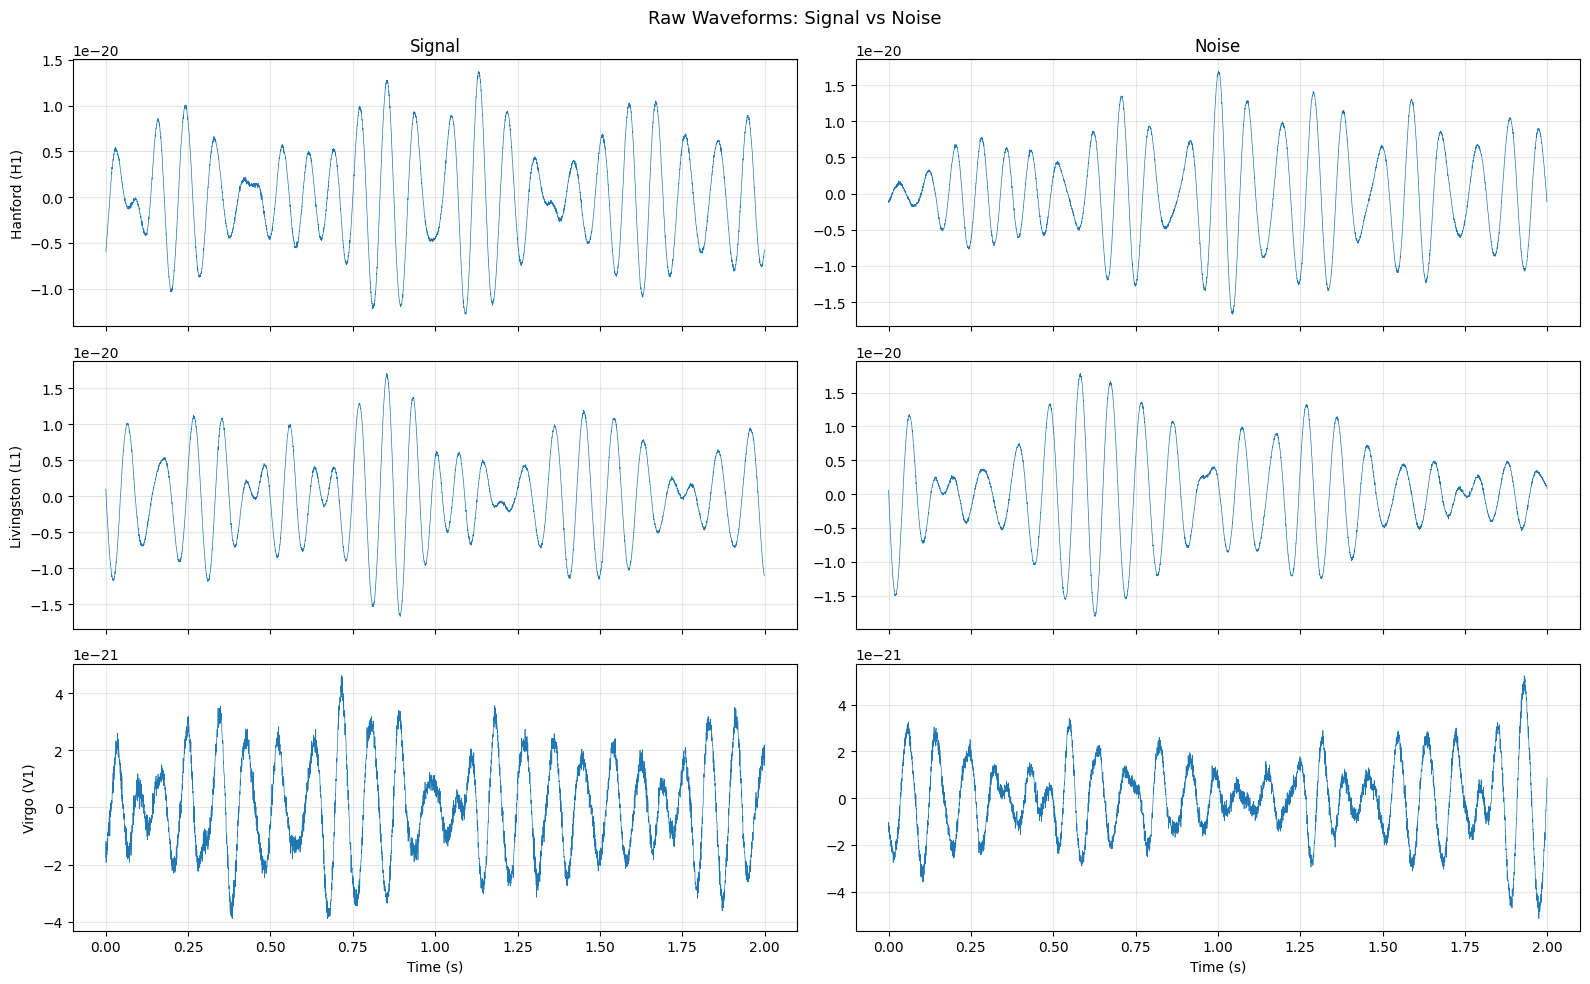

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True)

for i in range(3):
    for col, (data, label) in enumerate([(raw_signal, "Signal"), (raw_noise, "Noise")]):
        ax = axes[i, col]
        ax.plot(T, data[i], linewidth=0.5)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.set_title(label, fontsize=12)
        if col == 0:
            ax.set_ylabel(DETECTOR_NAMES[i], fontsize=10)

axes[2, 0].set_xlabel("Time (s)")
axes[2, 1].set_xlabel("Time (s)")
fig.suptitle("Raw Waveforms: Signal vs Noise", fontsize=13)
plt.tight_layout()
plt.show()

## 2. Frequency Content

The raw signals are dominated by *colored* noise: power that varies dramatically with frequency. Low-frequency seismic noise and high-frequency shot noise overwhelm any gravitational wave content. You can check this by noticing there's no discernible difference between the signal and noise spectrograms below:

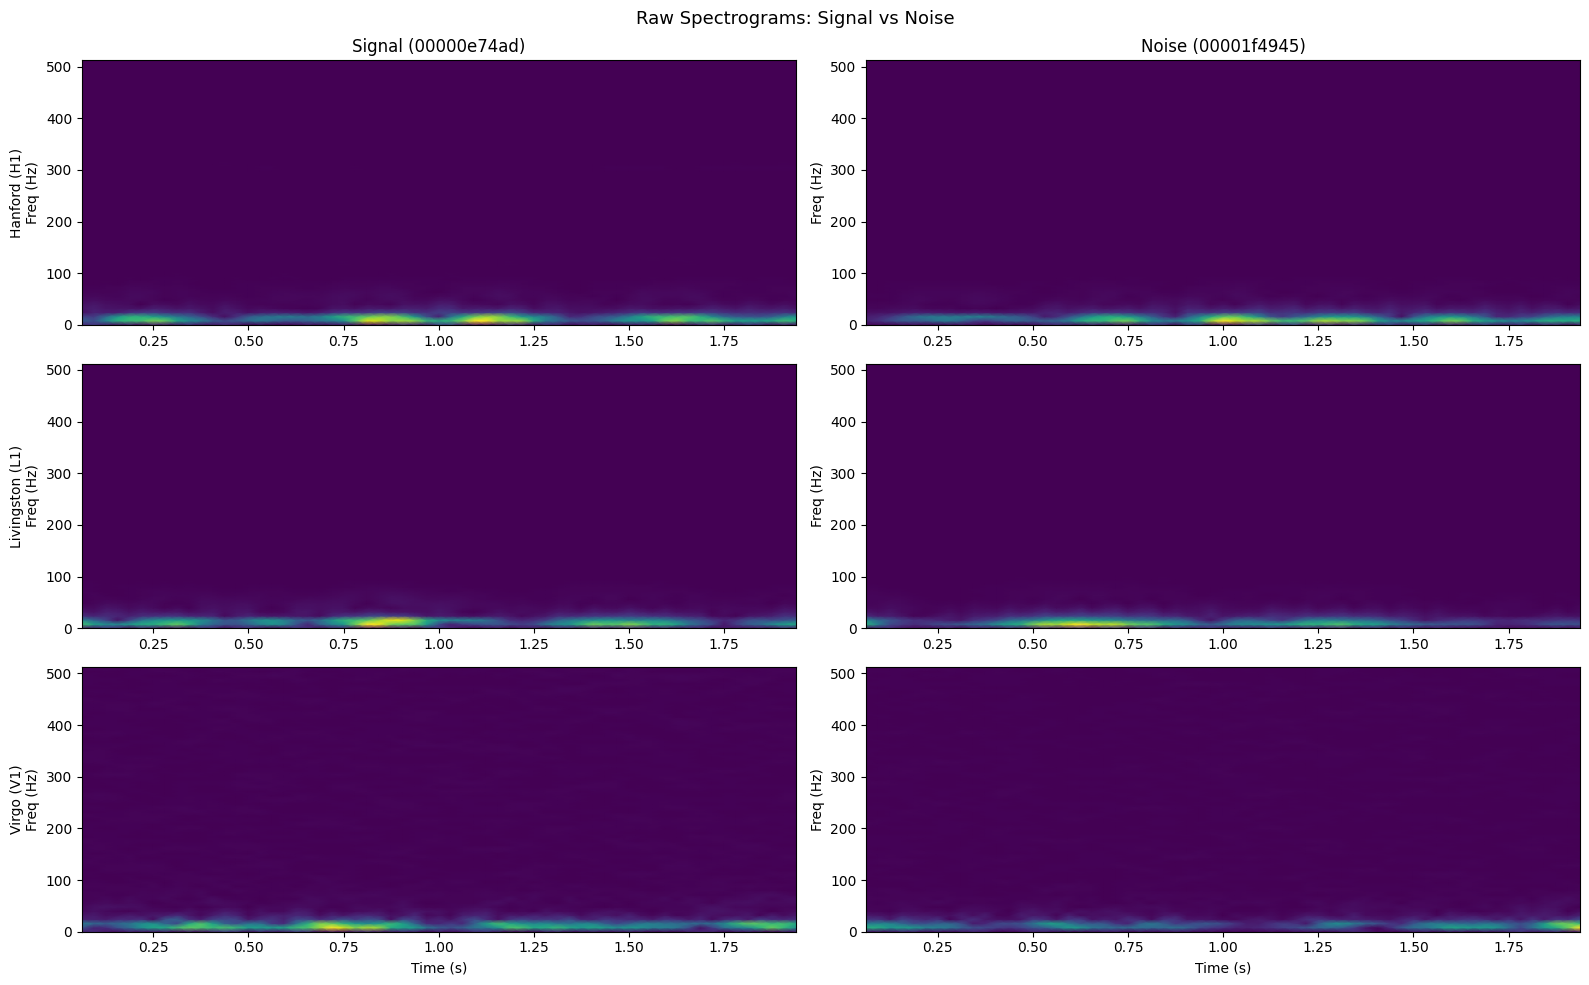

In [26]:
def plot_spectrograms(raw_signal, raw_noise, signal_id, noise_id,
                      fs=FS, nperseg=256, noverlap=192, fmax=512):
    """Side-by-side spectrograms for signal vs noise."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 10))

    for det in range(3):
        for col, (data, label) in enumerate([(raw_signal, "Signal"), (raw_noise, "Noise")]):
            f, t, Sxx = spectrogram(data[det], fs=fs, nperseg=nperseg,
                                    noverlap=noverlap, scaling="density",
                                    mode="magnitude")
            mask = f <= fmax
            axes[det, col].pcolormesh(t, f[mask], 10 * np.log10(Sxx[mask, :] + 1e-12),
                                      shading="gouraud")
            if det == 0:
                axes[det, col].set_title(f"{label} ({signal_id if col == 0 else noise_id})")
            if col == 0:
                axes[det, col].set_ylabel(f"{DETECTOR_NAMES[det]}\nFreq (Hz)")
            else:
                axes[det, col].set_ylabel("Freq (Hz)")

    axes[2, 0].set_xlabel("Time (s)")
    axes[2, 1].set_xlabel("Time (s)")
    fig.suptitle("Raw Spectrograms: Signal vs Noise", fontsize=13)
    plt.tight_layout()
    return fig


plot_spectrograms(raw_signal, raw_noise, signal_row["id"], noise_row["id"])
plt.show()

### Average Noise PSD

The noise power spectrum reveals the shape that whitening must flatten. The steep rise at low frequencies is seismic noise; the sustained, low rise at high frequencies is shot noise. The quiet band between ~30-400 Hz is where gravitational wave signals are potentially recoverable (see [THE_SCIENCE.md](../THE_SCIENCE.md#on-noise) for details).

Average PSD loaded from: avg_psd.npz  shape=(3, 2049)


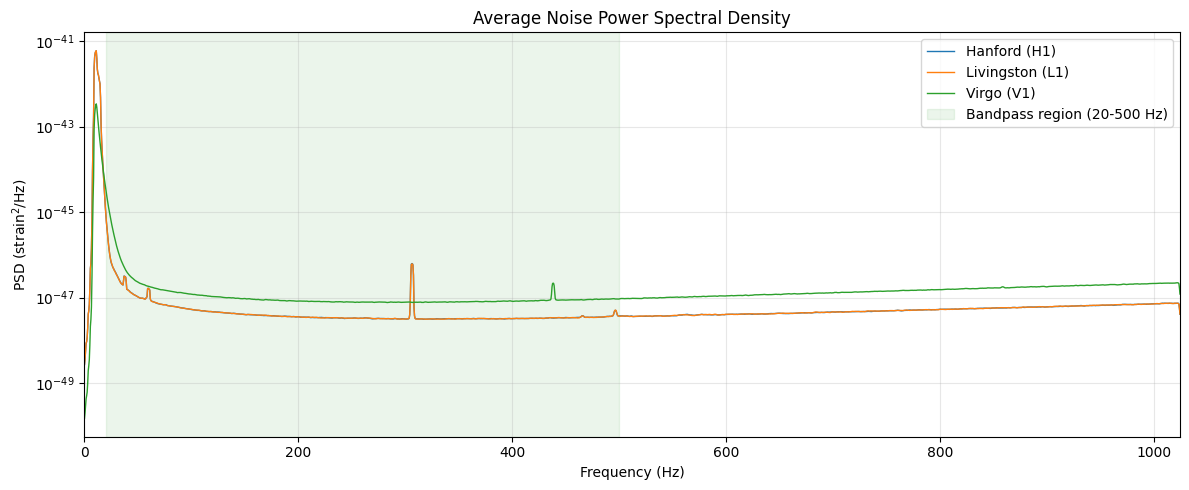

In [27]:
# find avg_psd.npz
psd_candidates = [
    PROJECT_ROOT / "kaggle" / "output" / "avg_psd.npz",
    PROJECT_ROOT / "avg_psd.npz",
    sample_dataset_dir(PROJECT_ROOT) / "avg_psd.npz",
]
psd_path = next((p for p in psd_candidates if p.exists()), None)
if psd_path is None:
    raise FileNotFoundError("avg_psd.npz not found. Run src/data/compute_psd.py first.")

avg_psd = load_psd(psd_path)
print(f"Average PSD loaded from: {psd_path.name}  shape={avg_psd.shape}")

# plot average PSD
freqs = np.fft.rfftfreq(N, d=1.0 / FS)

fig, ax = plt.subplots(figsize=(12, 5))
for i in range(3):
    ax.semilogy(freqs, avg_psd[i], linewidth=1, label=DETECTOR_NAMES[i])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"PSD (strain$^2$/Hz)")
ax.set_title("Average Noise Power Spectral Density")
ax.set_xlim([0, FS / 2])
ax.axvspan(20, 500, alpha=0.08, color="green", label="Bandpass region (20-500 Hz)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Preprocessing Pipeline

The preprocessing pipeline extracts the signal from the noise in four steps:

1. **Bandpass filter (20-500 Hz)** -- removes frequency bands where noise dominates completely.
2. **Spectral whitening** -- divides by the average noise PSD, flattening the noise floor so no single frequency band dominates.
3. **Tukey window** -- tapers the edges to reduce spectral leakage from the abrupt start/end of the 2-second window.
4. **Normalization** -- zero mean, unit variance per detector.

Below, each row shows one stage of the pipeline across all three detectors.

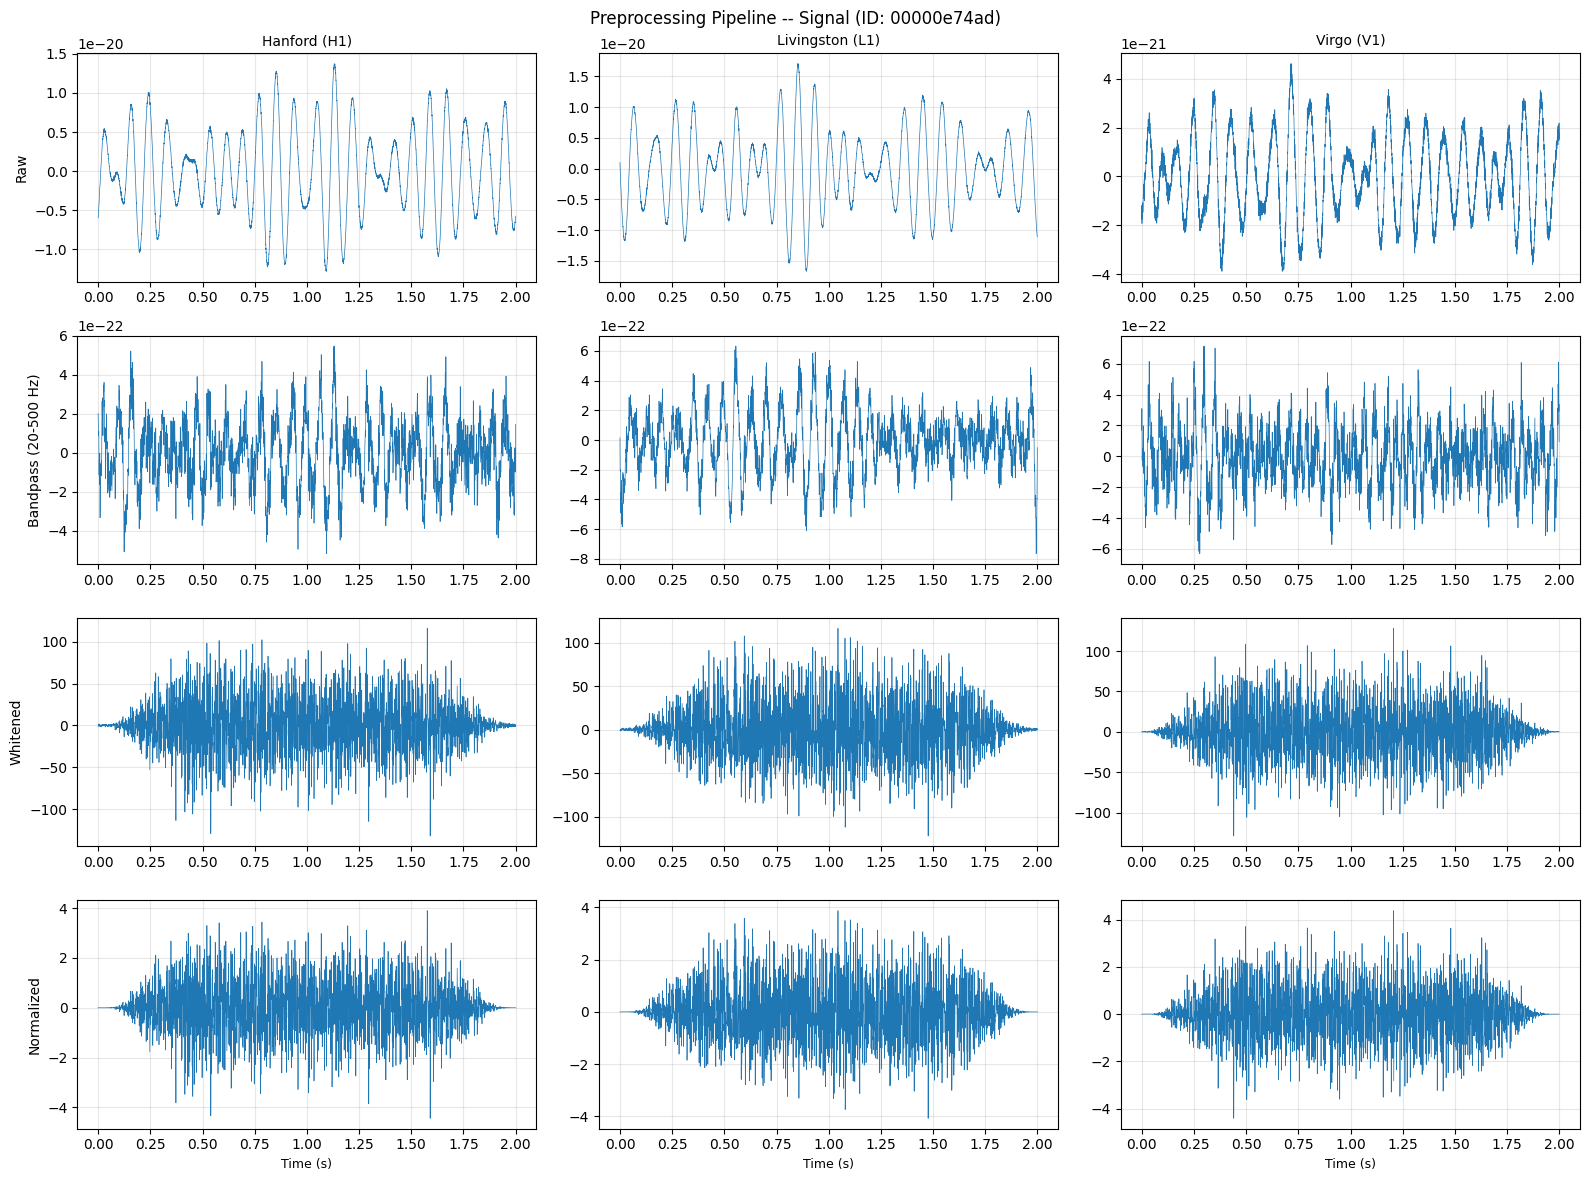

In [28]:
plot_preprocessing_pipeline(raw_signal, avg_psd, 1, signal_row["id"])
plt.show()

### Whitened Spectrograms: Signal vs Noise

After whitening, the noise floor becomes flat, i.e. no single frequency band dominates the spectrogram. Both plots below will most likely look similar to the eye: most signals in this dataset have SNR too low for the chirp to be visible, even after whitening. The difference is statistical, not visual, which is exactly why we need a model. In rare high-SNR samples, you may spot a faint upward-sweeping track (the famous *chirp*), but don't expect it here.

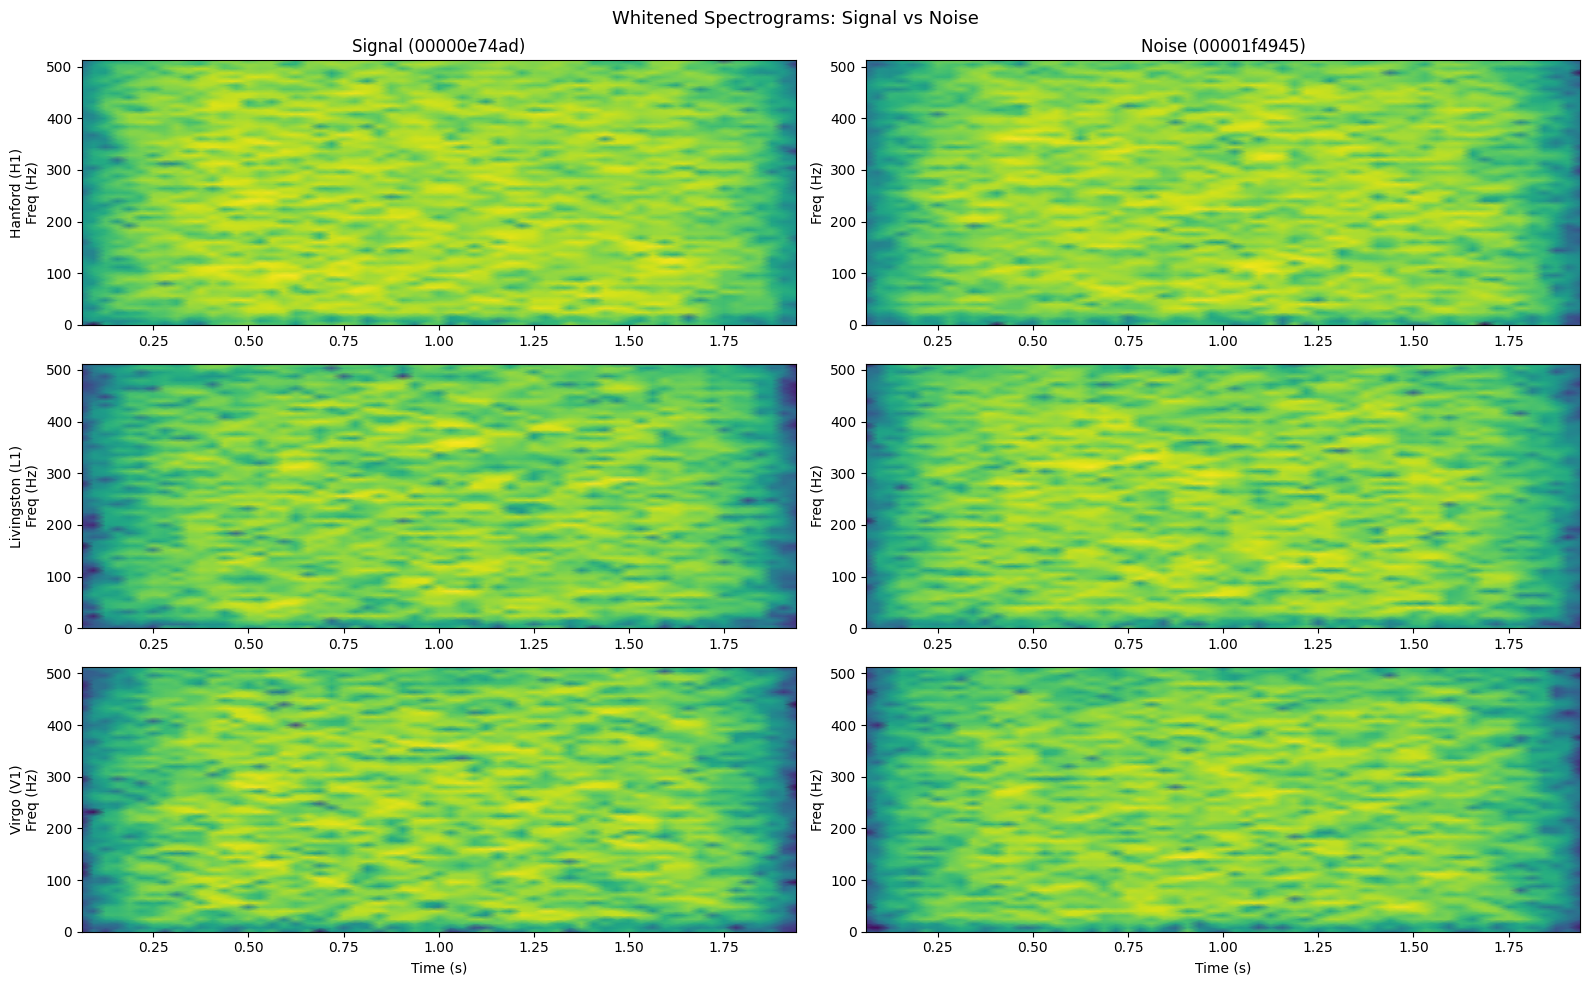

In [29]:
whitened_signal = preprocess_sample(raw_signal, avg_psd)
whitened_noise = preprocess_sample(raw_noise, avg_psd)


def plot_whitened_comparison(whitened_signal, whitened_noise, signal_id, noise_id,
                             fs=FS, nperseg=256, noverlap=192, fmax=512):
    """Side-by-side whitened spectrograms."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 10))

    for det in range(3):
        for col, (data, label, sid) in enumerate([
            (whitened_signal, "Signal", signal_id),
            (whitened_noise, "Noise", noise_id),
        ]):
            f, t, Sxx = spectrogram(data[det], fs=fs, nperseg=nperseg,
                                    noverlap=noverlap, scaling="density",
                                    mode="magnitude")
            mask = f <= fmax
            axes[det, col].pcolormesh(t, f[mask], 10 * np.log10(Sxx[mask, :] + 1e-12),
                                      shading="gouraud")
            if det == 0:
                axes[det, col].set_title(f"{label} ({sid})")
            if col == 0:
                axes[det, col].set_ylabel(f"{DETECTOR_NAMES[det]}\nFreq (Hz)")
            else:
                axes[det, col].set_ylabel("Freq (Hz)")

    axes[2, 0].set_xlabel("Time (s)")
    axes[2, 1].set_xlabel("Time (s)")
    fig.suptitle("Whitened Spectrograms: Signal vs Noise", fontsize=13)
    plt.tight_layout()
    return fig


plot_whitened_comparison(whitened_signal, whitened_noise, signal_row["id"], noise_row["id"])
plt.show()

## 4. Cross-Detector Correlation

A real gravitational wave arrives at each detector with a slight time delay determined by the source's sky position. The maximum possible delay is ~10 ms between the two LIGO sites and ~27 ms between LIGO and Virgo (set by light travel time). After whitening, noise in each detector is independent, so any correlated pattern across detectors is evidence of a shared signal.

The plots below show the normalized cross-correlation between each detector pair. For a high-SNR signal, you would see a peak within the physical lag bounds. For most samples in this dataset, the SNR is too low for a clear peak to emerge. As a result, the "peak" the plot labels is just the tallest noise fluctuation, often at an unphysical lag. The model learns this correlation structure statistically across many samples, not from any single example.

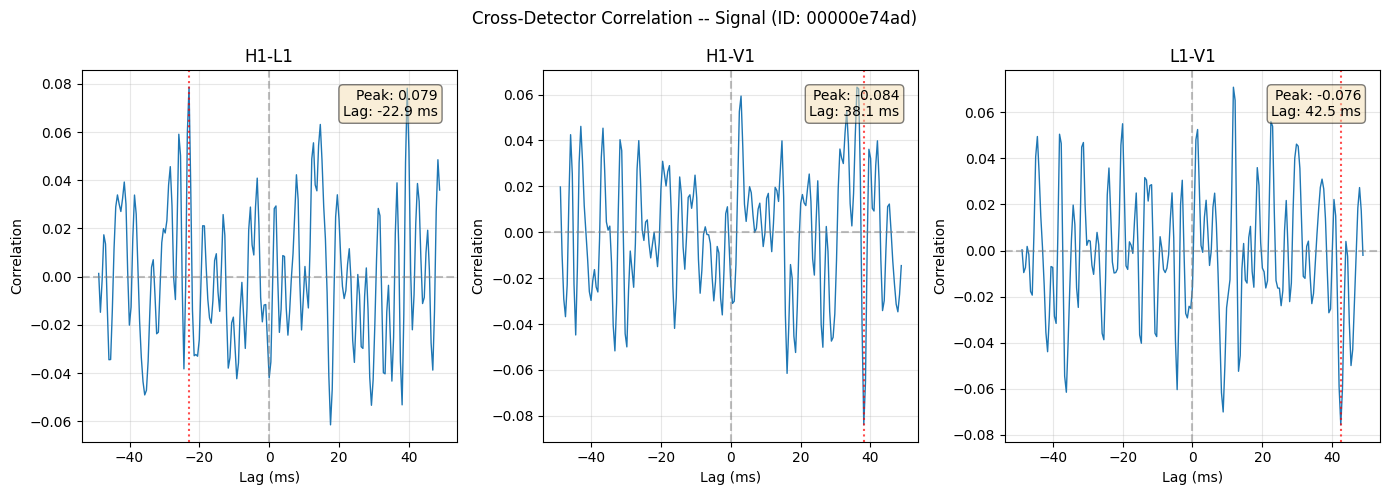

In [30]:
plot_cross_detector_correlation(raw_signal, avg_psd, 1, signal_row["id"])
plt.show()

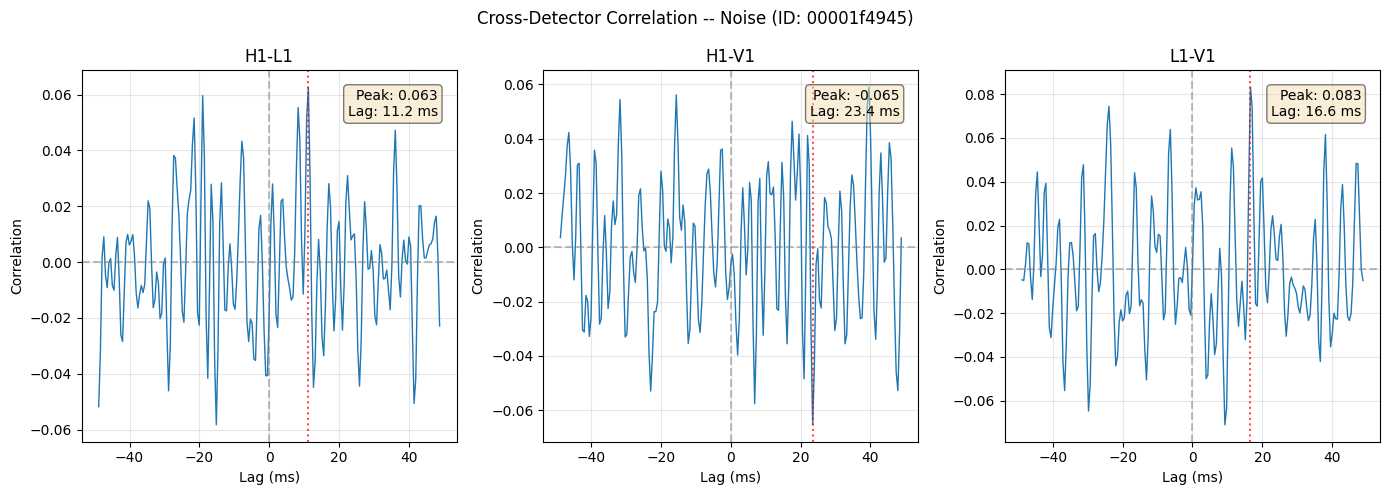

In [31]:
plot_cross_detector_correlation(raw_noise, avg_psd, 0, noise_row["id"])
plt.show()

## 5. Explore

Load a random sample and inspect its whitened waveform and spectrogram. Re-run this cell to see different samples.

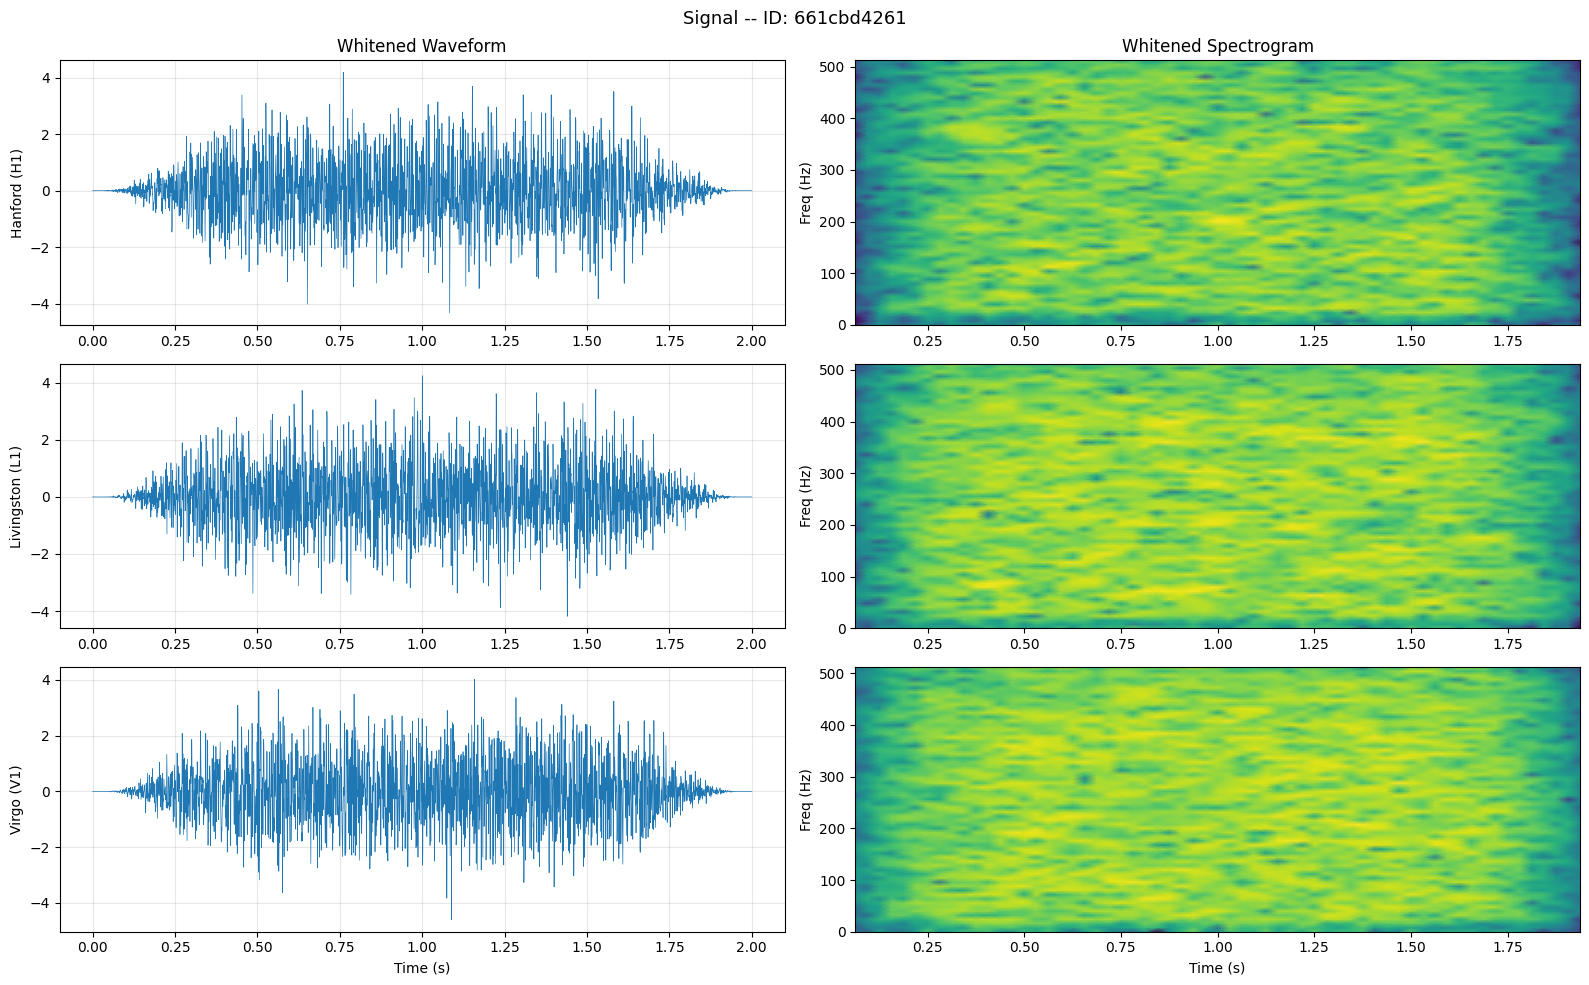

In [32]:
def explore_random_sample():
    """Load a random sample and show its whitened waveform + spectrogram."""
    row = labels_df.sample(1).iloc[0]
    raw = load_sample(row["id"], dataset_dir=DATASET_DIR)
    whitened = preprocess_sample(raw, avg_psd)
    label_str = "Signal" if row["target"] == 1 else "Noise"

    fig, axes = plt.subplots(3, 2, figsize=(16, 10))
    time = np.arange(N) / FS

    for det in range(3):
        # whitened waveform
        axes[det, 0].plot(time, whitened[det], linewidth=0.5)
        axes[det, 0].grid(True, alpha=0.3)
        axes[det, 0].set_ylabel(DETECTOR_NAMES[det])
        if det == 0:
            axes[det, 0].set_title("Whitened Waveform")

        # whitened spectrogram
        f, t, Sxx = spectrogram(whitened[det], fs=FS, nperseg=256,
                                noverlap=192, scaling="density", mode="magnitude")
        mask = f <= 512
        axes[det, 1].pcolormesh(t, f[mask], 10 * np.log10(Sxx[mask, :] + 1e-12),
                                 shading="gouraud")
        if det == 0:
            axes[det, 1].set_title("Whitened Spectrogram")
        axes[det, 1].set_ylabel("Freq (Hz)")

    axes[2, 0].set_xlabel("Time (s)")
    axes[2, 1].set_xlabel("Time (s)")
    fig.suptitle(f"{label_str} -- ID: {row['id']}", fontsize=13)
    plt.tight_layout()
    plt.show()


explore_random_sample()

---

The raw detector data is unreadable, and even after preprocessing most individual samples still look alike to the human eye. But preprocessing flattens the noise floor and brings the signal into the frequency band where it can exist, so a model trained on thousands of examples can learn the subtle statistical differences (whitened chirp morphology and cross-detector correlation) that separate signal from noise. To see how the model uses them, continue to [02_model_explorer.ipynb](02_model_explorer.ipynb). For planned improvements to the model, see [next-steps.md](../next-steps.md).